# Curso de Manejo de Datos Faltantes: Imputación

![Desarrollado por Diego Lerma](https://img.shields.io/badge/DiegoLerma-Desarrollado_Por?style=for-the-badge&logo=Accenture&label=Desarrollado%20por&color=%23265073)

![Curso de Manejo de Datos Faltantes: Exploración](https://www.shutterstock.com/image-illustration/creative-digital-business-screen-background-600nw-744577681.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [13]:
%run ../imputacion-module/utils/pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
(
    smf.ols(
        formula='temp ~ ozone',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Mon, 18 Mar 2024",Prob (F-statistic):,2.93e-18
Time:,11:13:48,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula='temp ~ ozone + solar_r',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Mon, 18 Mar 2024",Prob (F-statistic):,1.47e-16
Time:,11:13:48,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [7]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

In [8]:
survival_df.isna().sum()

age              0
sex              0
sample.yr        0
kappa            0
lambda           0
flc.grp          0
creatinine    1350
mgus             0
futime           0
death            0
chapter       5705
dtype: int64

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

#### Modelo 1

In [9]:
model_1=(
    smf.ols(
        formula='death ~ age + creatinine',
        data=survival_df
    )
    .fit()
)

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     1397.
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:13:50   Log-Likelihood:                -3007.5
No. Observations:                6524   AIC:                             6021.
Df Residuals:                    6521   BIC:                             6041.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2899      0.031    -41.981      0.000      -1.350      -1.230
age            0.0227      0.000     50.643      0.000       0.022       0.024
creatinine     0.1052      0.011      9.161      0.000       0.083       0.128
==============================================================================
Omnibus:                      366.605   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.640
Skew:                           0.622   Prob(JB):                     1.38e-93
Kurtosis:                       2.844   Cond. No.                         430.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Modelo 2

In [10]:
model_2=(
    smf.ols(
        formula='death ~ chapter + creatinine',
        data=survival_df
    )
    .fit()
)

model_2.summary()

/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -121.6
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               1.00
Time:                        11:13:50   Log-Likelihood:                 63518.
No. Observations:                1962   AIC:                        -1.270e+05
Df Residuals:                    1945   BIC:                        -1.269e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0000   1.06e-15   9.42e+14      0.000       1.000       1.000
chapter[T.Circulatory]           6.757e-15   1.06e-15      6.363      0.000    4.67e-15    8.84e-15
chapter[T.Congenital]            4.089e-15   1.64e-15      2.495      0.013    8.75e-16     7.3e-15
chapter[T.Digestive]             7.351e-15   1.09e-15      6.725      0.000    5.21e-15    9.49e-15
chapter[T.Endocrine]             5.995e-15   1.11e-15      5.410      0.000    3.82e-15    8.17e-15
chapter[T.External Causes]       6.861e-15    1.1e-15      6.265      0.000    4.71e-15    9.01e-15
chapter[T.Genitourinary]         8.867e-15   1.11e-15      7.958      0.000    6.68e-15    1.11e-14
chapter[T.Ill Defined]           5.858e-15   1.12e-15      5.250      0.000    3.67e-15    8.05e-15
chapter[T.Infectious]            4.837e-15   1.14e-15      4.253      0.000    2.61e-15    7.07e-15
chapter[T.Injury and Poisoning]  8.404e-15   1.16e-15      7.247      0.000    6.13e-15    1.07e-14
chapter[T.Mental]                9.456e-15   1.07e-15      8.800      0.000    7.35e-15    1.16e-14
chapter[T.Musculoskeletal]       6.836e-15   1.22e-15      5.589      0.000    4.44e-15    9.24e-15
chapter[T.Neoplasms]             2.923e-15   1.06e-15      2.750      0.006    8.39e-16    5.01e-15
chapter[T.Nervous]               6.828e-15   1.08e-15      6.344      0.000    4.72e-15    8.94e-15
chapter[T.Respiratory]           7.559e-15   1.07e-15      7.078      0.000    5.46e-15    9.65e-15
chapter[T.Skin]                  4.418e-15    1.5e-15      2.951      0.003    1.48e-15    7.35e-15
creatinine                       6.442e-16   8.42e-17      7.654      0.000    4.79e-16    8.09e-16
==============================================================================
Omnibus:                      175.789   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.613
Skew:                           0.483   Prob(JB):                     2.89e-26
Kurtosis:                       2.290   Cond. No.                         150.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Preparando datos: _National Health and Nutrition Examination Survey_

/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/missingno/missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


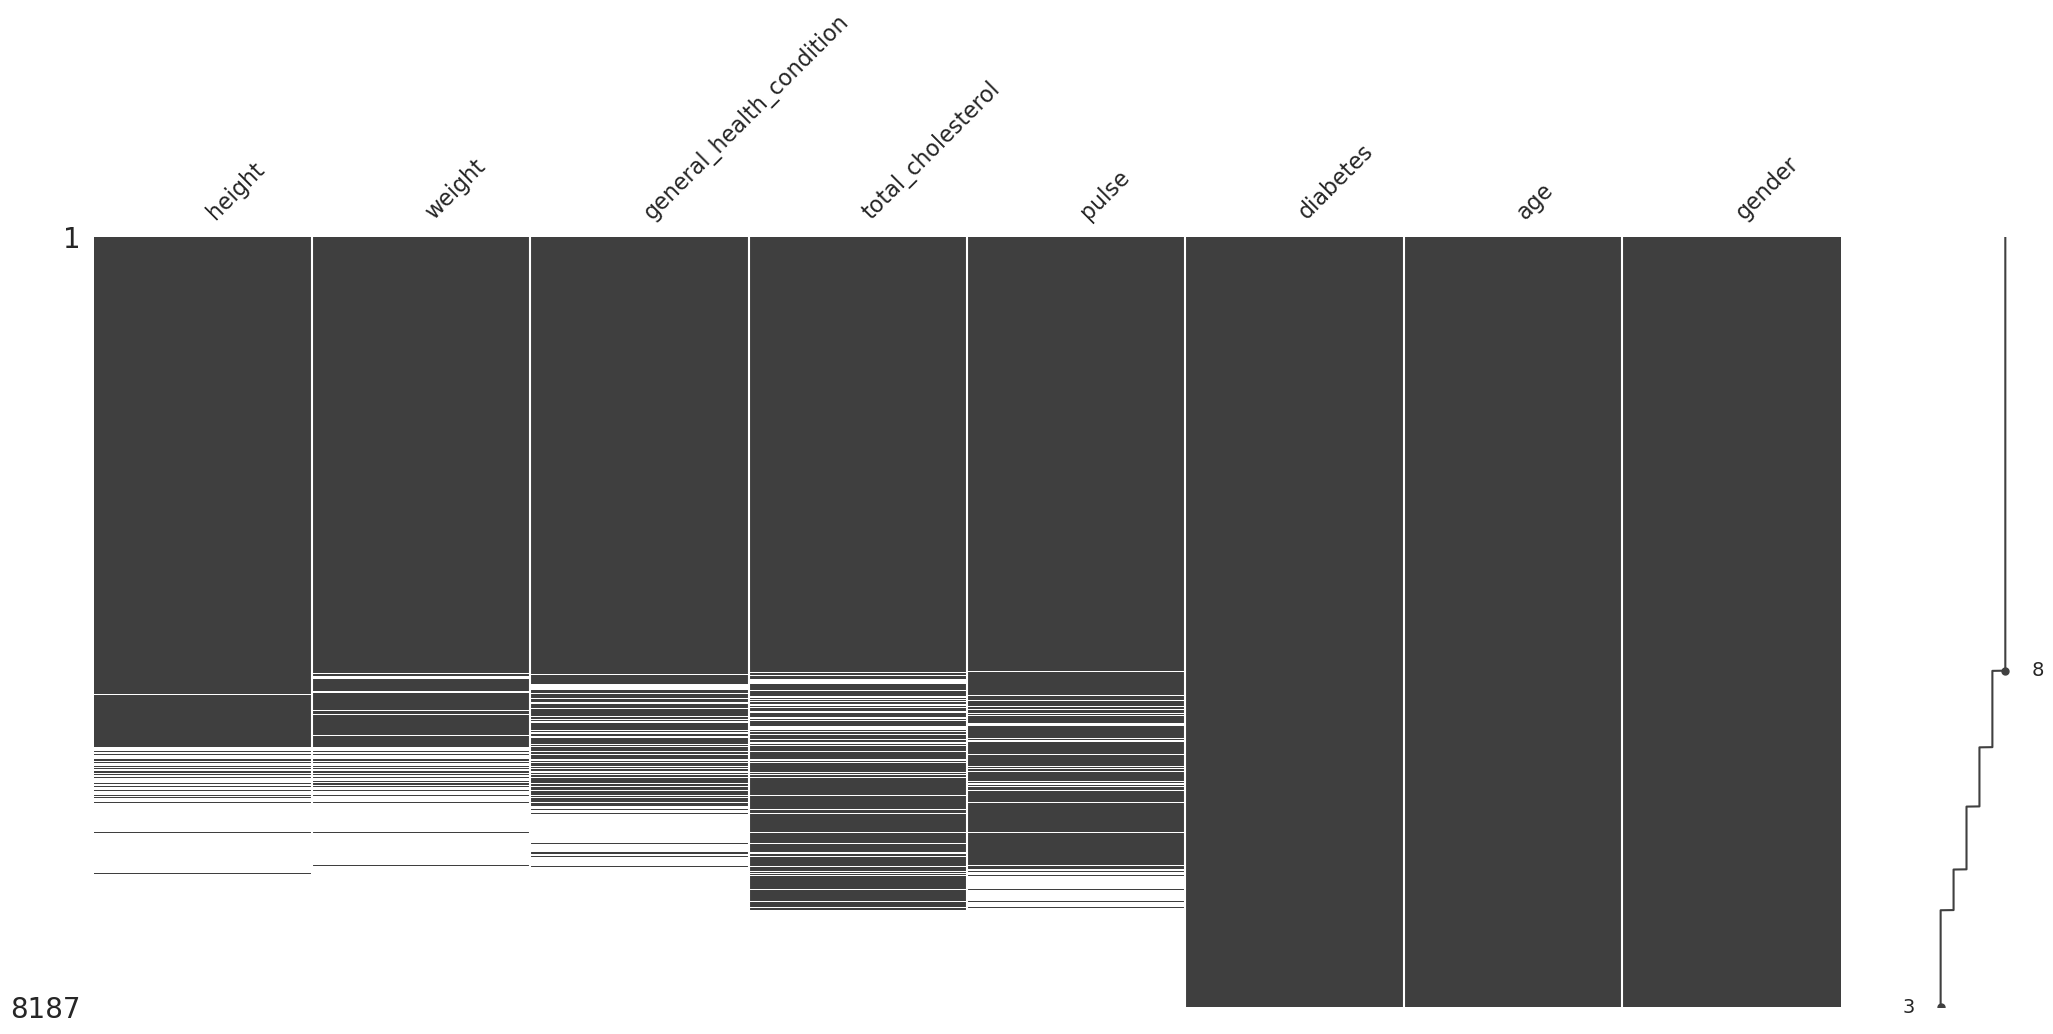

/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/upsetplot/plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/upsetplot/plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


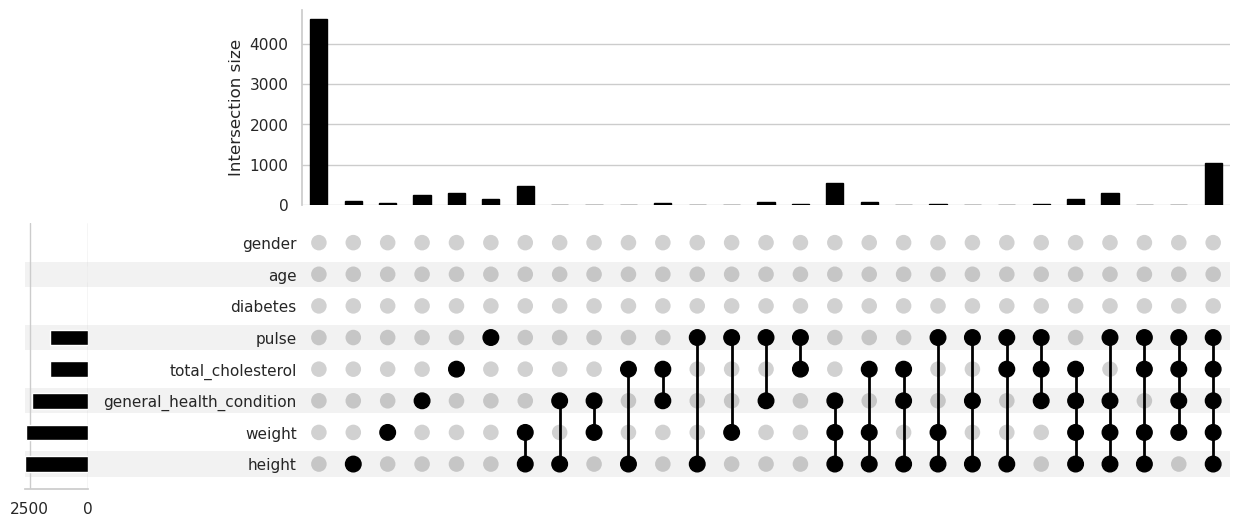

/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/missingno/missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


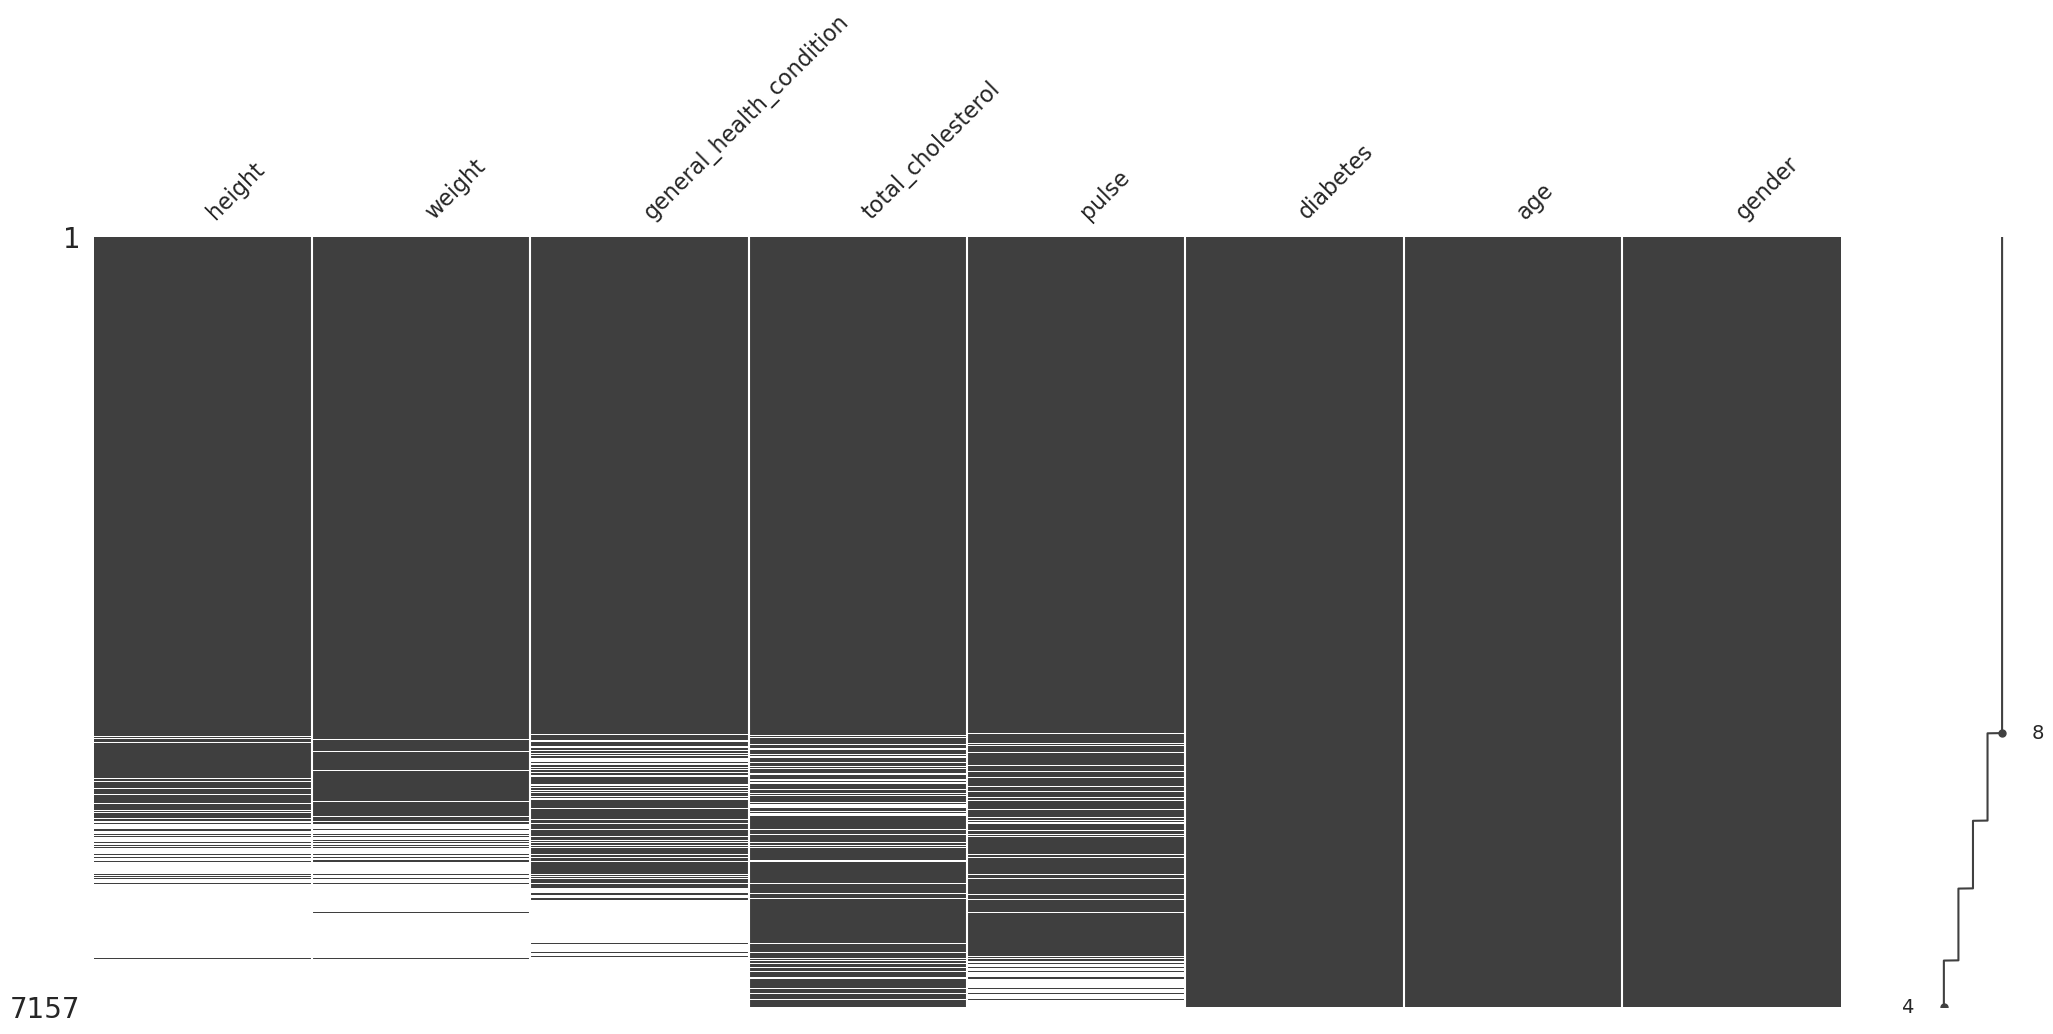

In [12]:
%run ../reports/download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![Manejo de valores faltantes](https://static.platzi.com/media/user_upload/mecanismos-0d8e7b18-8ed3-414d-8466-f6bf33a66b05.jpg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [20]:
female_weight, male_weight=(
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x : x.isna(),
        elementwise=False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df : (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a=female_weight, 
    b=male_weight,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

In [ ]:
female_weight

## Amplía tu conjunto de herramientas para explorar valores faltantes

## Tratamiento de variables categóricas para imputación de valores faltantes

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

#### Aplicando la codificación ordinal a todas tus variables categóricas

### _One Hot Encoding_

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

#### `skelearn.preprocessing.OneHotEncoder()`

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

## Imputación por interpolación

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [11]:
session_info.show()

/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing attr.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)
/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)
/home/diego/anaconda3/envs/imputacion-valores-faltantes/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing attrs.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>